In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

2025-04-23 23:13:09.317407: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 23:13:09.713094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 23:13:12.253635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
reviews = pd.read_csv('reviews1.csv')

In [3]:
print(reviews['Текст отзыва'][2])
print(reviews['Тональность'][2])

Плохо реагируют на жалобы, приходится ждать неделями.
отрицательный


In [4]:
reviews = reviews.iloc[:, :2]

tonality_mapping = {
    'отрицательный': 0,
    'нейтральный': 1,
    'положительный': 2
}

reviews['Тональность'] = reviews['Тональность'].map(tonality_mapping)

In [5]:
texts = reviews['Текст отзыва'].values
labels = reviews['Тональность'].values

vocab_size = 20000  # размер словаря
max_seq_length = 100  # максимальная длина последовательности

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# преобразуем метки в one-hot encoding (если мультиклассовая классификация)
num_classes = len(np.unique(labels))
if num_classes > 2:
    from tensorflow.keras.utils import to_categorical
    labels = to_categorical(labels)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [7]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError("embed_dim must be divisible by num_heads")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

def transformer_block(inputs, embed_dim, num_heads, dropout_rate=0.1):
    attention_output = MultiHeadSelfAttention(embed_dim, num_heads)(inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn = Dense(embed_dim * 4, activation="relu")(attention_output)
    ffn = Dense(embed_dim)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(attention_output + ffn)

def build_sentiment_model(
    vocab_size,  # Размер словаря
    max_seq_length,  # Максимальная длина последовательности
    embed_dim=128,  # Размерность эмбеддингов
    num_heads=8,  # Количество голов внимания
    num_layers=1,  # Количество трансформер-блоков
    dropout_rate=0.1,
    num_classes=1,  # 1 для бинарной классификации, >1 для мультиклассовой
):
    inputs = Input(shape=(max_seq_length,))
    
    x = Embedding(vocab_size, embed_dim)(inputs)

    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, dropout_rate)

    # Усреднение по временной оси
    x = GlobalAveragePooling1D()(x)
    
    outputs = Dense(num_classes, activation="sigmoid" if num_classes == 1 else "softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
model = build_sentiment_model(
    vocab_size=vocab_size,
    max_seq_length=max_seq_length,
    embed_dim=128,
    num_heads=4,
    num_layers=2,
    dropout_rate=0.2,
    num_classes=3 if num_classes > 2 else 1
)

if num_classes > 2:
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 128)             2560000   ['input_2[0][0]']             
                                                                                                  
 multi_head_self_attention_  (None, None, 128)            66048     ['embedding_1[0][0]']         
 1 (MultiHeadSelfAttention)                                                                       
                                                                                                  
 dropout_2 (Dropout)         (None, None, 128)            0         ['multi_head_self_attent

In [30]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10


2025-04-23 14:27:26.930648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-23 14:27:27.095002: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb2e4c3cd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-23 14:27:27.095039: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-23 14:27:27.114647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-23 14:27:27.156833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-04-23 14:27:27.239174: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1.

 1/24 [>.............................] - ETA: 2:01 - loss: 2.1665 - accuracy: 0.2500

2025-04-23 14:27:29.386863: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 2/24 [=>............................] - ETA: 4s - loss: 2.4493 - accuracy: 0.2812  

2025-04-23 14:27:29.638389: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:29.825506: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 5/24 [=====>........................] - ETA: 2s - loss: 2.6356 - accuracy: 0.3063

2025-04-23 14:27:29.988467: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:30.147612: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 8/24 [=========>....................] - ETA: 2s - loss: 2.1213 - accuracy: 0.3477

2025-04-23 14:27:30.306455: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:30.451048: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



11/24 [============>.................] - ETA: 1s - loss: 1.9502 - accuracy: 0.3466

2025-04-23 14:27:30.627925: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:30.769182: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



13/24 [===============>..............] - ETA: 1s - loss: 1.8146 - accuracy: 0.3510

2025-04-23 14:27:30.949194: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:31.121882: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



17/24 [====================>.........] - ETA: 0s - loss: 1.6716 - accuracy: 0.3309

2025-04-23 14:27:31.271546: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:31.410881: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



18/24 [=====================>........] - ETA: 0s - loss: 1.6465 - accuracy: 0.3247

2025-04-23 14:27:31.572471: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:31.773002: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - ETA: 0s - loss: 1.5265 - accuracy: 0.3298

2025-04-23 14:27:32.069373: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 8s 136ms/step - loss: 1.5265 - accuracy: 0.3298 - val_loss: 1.1862 - val_accuracy: 0.3122
Epoch 2/10
 3/24 [==>...........................] - ETA: 3s - loss: 1.1622 - accuracy: 0.3125

2025-04-23 14:27:32.743737: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:32.889272: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 9/24 [==========>...................] - ETA: 1s - loss: 1.1317 - accuracy: 0.3264

2025-04-23 14:27:33.136478: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



11/24 [============>.................] - ETA: 1s - loss: 1.1284 - accuracy: 0.3295

2025-04-23 14:27:33.425566: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:33.575123: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



17/24 [====================>.........] - ETA: 0s - loss: 1.1289 - accuracy: 0.3327

2025-04-23 14:27:33.874654: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



23/24 [===========================>..] - ETA: 0s - loss: 1.1262 - accuracy: 0.3356

2025-04-23 14:27:34.267375: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - ETA: 0s - loss: 1.1251 - accuracy: 0.3364

2025-04-23 14:27:34.551306: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 2s 95ms/step - loss: 1.1251 - accuracy: 0.3364 - val_loss: 1.0716 - val_accuracy: 0.3228
Epoch 3/10
 4/24 [====>.........................] - ETA: 2s - loss: 1.0540 - accuracy: 0.4609

2025-04-23 14:27:35.120704: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



15/24 [=================>............] - ETA: 0s - loss: 0.7400 - accuracy: 0.7229

2025-04-23 14:27:35.844359: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



20/24 [========================>.....] - ETA: 0s - loss: 0.6253 - accuracy: 0.7781

2025-04-23 14:27:36.218119: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:36.369679: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 2s 84ms/step - loss: 0.5545 - accuracy: 0.8045 - val_loss: 0.1603 - val_accuracy: 0.9788


2025-04-23 14:27:36.648913: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Epoch 4/10
14/24 [================>.............] - ETA: 0s - loss: 0.0401 - accuracy: 0.9844

2025-04-23 14:27:37.460507: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 1s 61ms/step - loss: 0.0407 - accuracy: 0.9867 - val_loss: 0.5098 - val_accuracy: 0.8836
Epoch 5/10


2025-04-23 14:27:38.096752: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



14/24 [================>.............] - ETA: 0s - loss: 0.0526 - accuracy: 0.9844

2025-04-23 14:27:38.860256: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



23/24 [===========================>..] - ETA: 0s - loss: 0.0349 - accuracy: 0.9905

2025-04-23 14:27:39.351369: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 1s 62ms/step - loss: 0.0342 - accuracy: 0.9907 - val_loss: 0.1195 - val_accuracy: 0.9841
Epoch 6/10


2025-04-23 14:27:39.580170: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 3/24 [==>...........................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

2025-04-23 14:27:39.917232: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-04-23 14:27:40.056458: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 2s 66ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1113 - val_accuracy: 0.9894
Epoch 7/10


2025-04-23 14:27:41.148375: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 1s 55ms/step - loss: 4.7256e-04 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9894
Epoch 8/10


2025-04-23 14:27:42.469041: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 1s 49ms/step - loss: 2.9639e-04 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9894
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 2.3002e-04 - accuracy: 1.0000

2025-04-23 14:27:44.988632: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/24 [==============================] - 1s 57ms/step - loss: 2.3002e-04 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9894
Epoch 10/10
24/24 [==============================] - 1s 50ms/step - loss: 1.9129e-04 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9894


6/6 [==============================] - 0s 55ms/step - loss: 0.1083 - accuracy: 0.9894
Test Accuracy: 98.94%


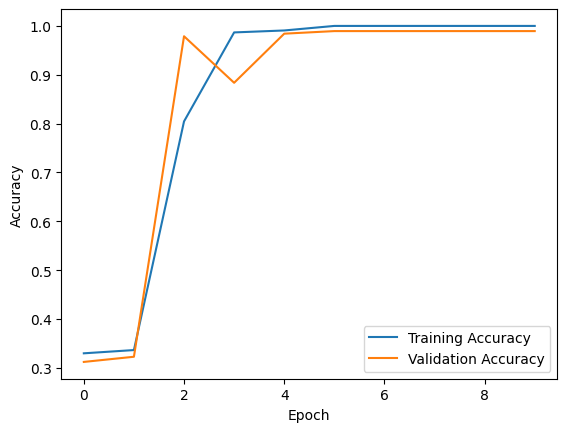

In [32]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy*100:.2f}%')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_seq_length, padding='post', truncating='post')
    prediction = model.predict(padded)
    
    if num_classes > 2:
        return np.argmax(prediction)
    else:
        return 1 if prediction > 0.5 else 0

sample_text = "olisadgjho ewrhigucivu nshjfsndsg"
tonality_mapping = {
    0: 'отрицательный',
    1: 'нейтральный',
    2: 'положительный'
}
print(f"Predicted sentiment: {tonality_mapping[predict_sentiment(sample_text)]}")

1/1 [==============================] - 0s 61ms/step
Predicted sentiment: нейтральный


In [39]:
model.save('beta_sentiment_analyzer.h5')

/home/makstrr/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
with keras.utils.custom_object_scope({'MultiHeadSelfAttention': MultiHeadSelfAttention}):
    model = keras.models.load_model('beta_sentiment_analyzer.h5')

2025-04-23 23:15:54.598906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-23 23:15:54.818257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-23 23:15:54.818681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-23 23:15:54.819991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-23 23:15:54.820414: I tensorflow/compile